In [2]:

import numpy as np
from sentence_transformers import SentenceTransformer
import ipywidgets as widgets
from matplotlib import pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))

2025-03-09 23:32:34.429357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741555954.446594   21754 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741555954.451433   21754 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 23:32:34.468307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
mode = "Test"
sentences = []

def on_value_change(change):
    global mode
    mode = change['new']

radio = widgets.RadioButtons(
    options=['Test', 'Query', 'Input'],
    value='Test',
    description="Select:"
)
radio.observe(on_value_change, names="value")
display(radio)

RadioButtons(description='Select:', options=('Test', 'Query', 'Input'), value='Test')

In [64]:
if mode == "Test":
    sentences = [
        "Given an input text, it outputs a vector which captures the semantic information",
        "By default, input text longer than 256 word pieces is truncated."
    ]
elif mode == "Query":
    
    from query import parse_queries, query, elasticsearch_client
    import metrics

    q = input("Query number: ")
    if q == "":
        q = 0
    else: q = int(q)

    query_list = parse_queries("../collection")[q:q+1]
    docs, multiple_query_results = query(elasticsearch_client("../credentials.json", "../http_ca.crt"), query_list)
    sentences = docs[0][0].split(". ")[:-1]
    print(f"{query_list[0].text}")
    print(f"Returned doc {multiple_query_results[0][0]} with relevance {metrics.relevance(multiple_query_results[0][0], query_list[0])}")
elif mode == "Input":
    doc = input("Give text: ")
    sentences = doc.split(". ")[:-1]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)

try docs:
30, 80

In [65]:
for s in sentences:
    print(s.strip())
    print()

The sun slowly sank behind the horizon, casting a warm glow over the quiet park

The golden light spread across the sky, painting everything in shades of orange and pink

As the evening wore on, the colors deepened, giving the sky a rich, fiery hue

People lingered by the lake, enjoying the peaceful scene as the sun dipped lower

The air grew cooler, and the park seemed to settle into a quiet calm, with only the soft rustling of leaves breaking the silence



In [66]:
def cosine_sim(vec1, vec2) -> float:
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

series = []

for vec1, vec2 in zip(embeddings[:-1], embeddings[1:]):
    series.append(cosine_sim(vec1, vec2))

print("\n".join(map(str, series)))

0.39245623
0.60072106
0.42832473
0.40186664


## Time series of sentence similarity
---

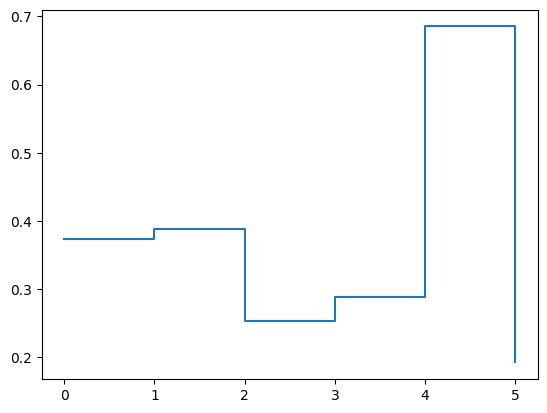

In [44]:
fig, ax = plt.subplots()

#ax.plot(series)
ax.step(np.arange(len(series)), series, where='post')
ax.set_xticks(np.arange(len(series)))
plt.show()

## Gradient
---

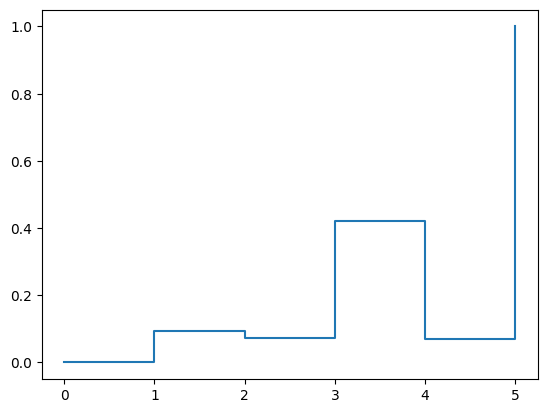

In [27]:
def normalize(arr):
    arr = list(map(abs, arr))
    maxval = max(arr)
    minval = min(arr)

    return list(map(lambda elem: (elem - minval)/(maxval-minval), arr))

dy = np.gradient(series, np.arange(len(series)))  # Compute numerical derivative

fig2, ax2 = plt.subplots()

#ax2.plot(normalize(dy))
ax2.step(np.arange(len(series)), normalize(dy),where='post')
#ax2.step(np.arange(len(series)), dy, where='post')
ax2.set_xticks(np.arange(len(series)))
plt.show()

# Continue

2.1324338912963867
1.3477068543434143
0.8725902438163757
0.39927905797958374
3


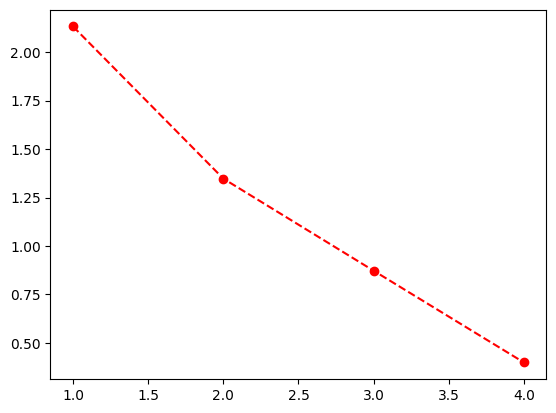

Clustering: [2 1 1 0 2]
Medoids: [3 1 4]


In [70]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from kmedoids import KMedoids
import hdbscan
from kneed import KneeLocator
from sklearn.decomposition import PCA

num_clusters = 2

'''
# Generate the linkage matrix
Z = linkage(embeddings, method='ward')
print(Z)
labels = fcluster(Z, t=num_clusters, criterion='maxclust')

#Organize each cluster elements into lists
clusters = [[] for _ in range(num_clusters)]

for i, cluster in enumerate(clusters):
    print(f"Cluster {i:02}: {cluster}")

#Evaluate clustering
score = silhouette_score(embeddings, labels)
print(f"\nSilhouette Score: {score:.3f}")'
'''

'''
dista = (1 - cosine_similarity(embeddings)).astype(np.float64)

clustering = hdbscan.HDBSCAN(min_cluster_size=2, metric="precomputed")
model = clustering.fit(dista)
print(model.labels_)

clusters = [[] for _ in range(num_clusters)]

for i, cluster in enumerate(clusters):
    print(f"Cluster {i:02}: {cluster}")

score = silhouette_score(embeddings, model.labels_)
print(f"\nSilhouette Score: {score:.3f}")'
'''
dista = cosine_distances(embeddings)

inertia = []
K_range = list(range(1, len(sentences)))

#Find optimal cluster count
for k in K_range:
    clustering = KMedoids(n_clusters=k, metric="precomputed")
    clustering_model = clustering.fit(dista)
    inertia.append(clustering_model.inertia_)
    print(clustering_model.inertia_)

knee_locator = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow
optimal_k = 3
print(optimal_k)

fig, ax = plt.subplots()
ax.plot(K_range, inertia, "ro--")
plt.show()

#Cluster optimal
clustering = KMedoids(n_clusters=int(optimal_k), metric="precomputed")
clustering_model = clustering.fit(dista)
medoids = clustering_model.medoid_indices_
print(f"Clustering: {clustering_model.labels_}")
print(f"Medoids: {medoids}")

Here's another idea
Let's compare the query with each sentence

In [68]:
if mode == "Query":
    print(f"Query: {query_list[0].text}")
    query_vec = model.encode(query_list[0].text)

    embedding_norms = np.linalg.norm(embeddings, axis=1)
    query_sim = np.dot(embeddings, query_vec)
    print(query_sim)

    sorted_sentences = sorted(sentences, key=lambda x: query_sim[sentences.index(x)], reverse=True)
    print(sorted_sentences)

Visualize clusters and query

[0 2 2 1 0]
0.1908399


/tmp/ipykernel_21754/1441523549.py:16: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(elem[0], elem[1], c=colors[clustering_model.labels_[i]], edgecolors='k', alpha=0.7, marker=markers[i])


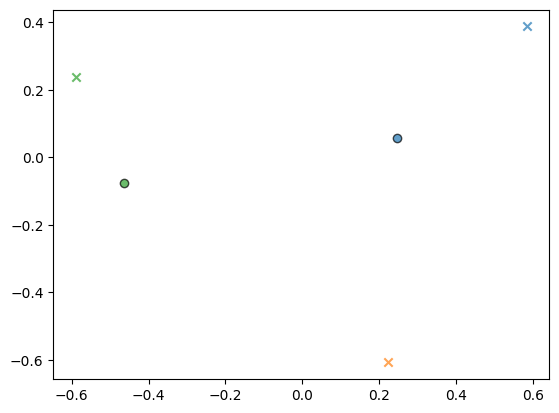

In [69]:
pca_model = PCA(n_components=2)

S = pca_model.fit_transform(embeddings)

if mode == "Query":
    query_vec_reduced = pca_model.transform(query_vec.reshape(1, -1))
    print(query_vec_reduced)

fig, ax = plt.subplots()

markers = ["x" if i in medoids else "o" for i in range(len(sentences))]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, elem in enumerate(S):
    ax.scatter(elem[0], elem[1], c=colors[clustering_model.labels_[i]], edgecolors='k', alpha=0.7, marker=markers[i])

if mode == "Query":
    ax.scatter(query_vec_reduced[0, 0], query_vec_reduced[0, 1], c="red", edgecolors='k', alpha=0.7, marker="^")

print(clustering_model.labels_)

print(silhouette_score(dista, clustering_model.labels_, metric="precomputed"))